# Helping Homeless Pets to be Adapted Sooner

## 1. The Task 
In this research would use hybrid data (image, text and structured data) collected by a pet adoption website to predict how fast a pet would be adopted.

Link to the Kaggle competition: https://www.kaggle.com/c/petfinder-adoption-prediction/

## 2. The Plan
### The Target column needs same treatment: Up sampling some categories

### Several new features could be created (would be used as structured data) 


1. Create 2 features: "desc_lang" based on the language of "Description": "desc_eng" which contains descriptions translated into English if they are in other languages.


2. Create 1 feature "sent_score" base on data in train_sentiment folder, which contails json files of results produced by Google's Natural Language API on each "Description".


3. Create 3 features based on "Name": 

   1) "name_lang": optional, language of the name. 

   2) "name_freq", we create the feature assuming that if the Name of the pets are more popular, would the pets be adapted sooner. 
   

### Multi-layer stacking techniques would be applied, it may include
1. One model based on Description (text) vs Target

   The Description column would have 2 data preparation procedures: 
   
   1) Language detection; 
   
   2) To translate non-English descriptions into English.
   

2. One model based on Image (image) vs Target


3. One/several models based on structured data vs Target combining with the above mentioned 2 models


## 3. Data Preparation

3.1. Change data type, investigate Target column and missing value (Not finished)

3.2 Treatment of "Description" (Text) Feature, Create 2 Features "desc_lang" and "desc_eng"

3.2.1 Description's treatment 1: replace null and " " with "na"

3.2.2 Description's treatment 2: language detection

3.2.3 Description's treatment 3: Translate non English into English, save to "lang_eng" (Not Done)

3.2.4 Description's treatment 4: text cleaning

3.3 Created "sent_score" base on data in train_sentiment folder (Not Done)

3.4 Treatment of "Name" (Text) Feature and creating 3 new features (Not Done)

3.4.1 Name treatment 1: Change "No name" "no name yet", "unknown", missing value to "no specific name" (Not Done)

3.4.2 Name treatment 2: language detection and creating 1 feature "name_lang"

3.4.3 Name treatment 3:  Removing punctuation, to lower case and creating 1 feature "name_freq" (Not Done)

3.5 Create 1 feature "video_binary" based on whether there is video or not (Not Done)

3.6 Create 1 feature "quantity_one_binary" based on whether the quantity is one or not (Not Done)

## 3.1. Change data type, investigate Target column and missing value

In [237]:
import pandas as pd
import numpy as np
from langdetect import detect
import copy
from googletrans import Translator

from nltk.corpus import stopwords  
from textblob import Word

import os
import json

from sklearn.feature_extraction.text import TfidfVectorizer
#import model_evaluation_utils as meu
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split

In [193]:
train = pd.read_csv("train.csv")

In [194]:
train.head(2)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0


### Change categorical data to categorical data type

### Check target column's distribution
0 - Pet was adopted on the same day as it was listed. 

1 - Pet was adopted between 1 and 7 days (1st week) after being listed. 

2 - Pet was adopted between 8 and 30 days (1st month) after being listed. 

3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed. 

4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

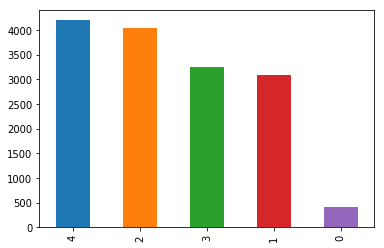

In [195]:
train['AdoptionSpeed'].value_counts().plot(kind='bar')

In [196]:
train.AdoptionSpeed.value_counts()

4    4197
2    4037
3    3259
1    3090
0     410
Name: AdoptionSpeed, dtype: int64

### Check Type column's distribution
1 = Dog, 2 = Cat

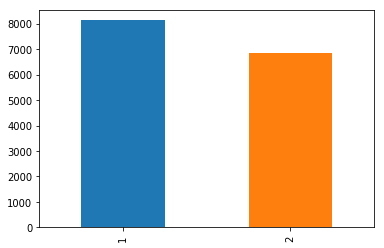

In [197]:
train.Type.value_counts().plot(kind='bar')

In [198]:
train.Type.value_counts()

1    8132
2    6861
Name: Type, dtype: int64

### Check PhotoAmt column's distribution

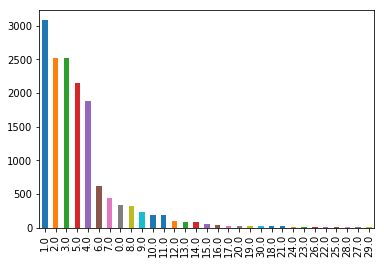

In [199]:
train.PhotoAmt.value_counts().plot(kind='bar')

In [200]:
train.PhotoAmt.value_counts()

1.0     3075
2.0     2518
3.0     2511
5.0     2147
4.0     1881
6.0      621
7.0      432
0.0      341
8.0      314
9.0      231
10.0     190
11.0     184
12.0      97
13.0      86
14.0      78
15.0      50
16.0      39
17.0      27
20.0      25
19.0      20
30.0      19
18.0      18
21.0      16
24.0      15
23.0      12
26.0      10
22.0       9
25.0       8
28.0       7
27.0       6
29.0       6
Name: PhotoAmt, dtype: int64

### Check VideoAmt column's distribution

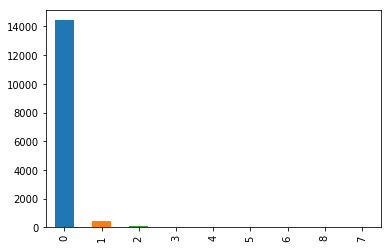

In [201]:
train.VideoAmt.value_counts().plot(kind='bar')

In [202]:
train.VideoAmt.value_counts()

0    14419
1      417
2       92
3       36
4       15
5        7
6        4
8        2
7        1
Name: VideoAmt, dtype: int64

### Check Quantity column's distribution¶

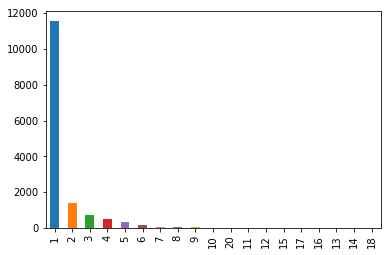

In [203]:
train.Quantity.value_counts().plot(kind='bar')

### Check State column's distribution
41326: Selangor 

"Selangor surrounds the federal territories of Kuala Lumpur and Putrajaya, both of which were previously part of it."
"It is the most developed state in Malaysia; it has good infrastructure such as highways and transport, and has the largest population in Malaysia, a high standard of living and the lowest poverty rate in the country." 
Reference: https://en.wikipedia.org/wiki/Selangor

41401: Kuala Lumpur

It is the national capital and "largest city in Malaysia".
Reference: https://en.wikipedia.org/wiki/Kuala_Lumpur

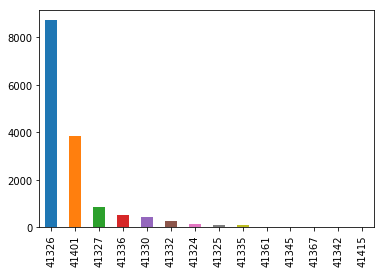

In [204]:
train.State.value_counts().plot(kind='bar')

### Check missing value in "train" table

In [205]:
train.isnull().sum()

Type                0
Name             1257
Age                 0
Breed1              0
Breed2              0
Gender              0
Color1              0
Color2              0
Color3              0
MaturitySize        0
FurLength           0
Vaccinated          0
Dewormed            0
Sterilized          0
Health              0
Quantity            0
Fee                 0
State               0
RescuerID           0
VideoAmt            0
Description        12
PetID               0
PhotoAmt            0
AdoptionSpeed       0
dtype: int64

## 3.2 Treatment of "Description" (Text) Feature, Create 2 Features "desc_lang" and "desc_eng"

### 3.2.1 Description's treatment 1: replace null and " " with "na"

In [206]:
# there are 12 rows with Description is missing value
train[train['Description'].isnull()].shape

(12, 24)

In [207]:
# there are 15 rows with just a space as Description
train[train['Description']==''].shape

(0, 24)

In [208]:
# transform both above rows a value "na" as Description
train['Description'] = np.where(train['Description']=='' , "na", train['Description'])
train['Description'] = np.where(train['Description'].isnull() , "na", train['Description'])

### 3.2.2 Description's treatment 2: language detection

In [209]:
# language detection
def try_detect(cell):
    try:
        detected_lang = detect(cell)
    except:
        detected_lang = None
    return detected_lang

text_detect = []

for Description in train['Description']:
    lang = try_detect(Description)
    text_detect.append(lang)

#print(text_detect)
train['desc_lang'] = train.Description.apply(try_detect)

Note: each time we run the languange detection function, the results of "desc_lange" may slightly differ

In [210]:
train.desc_lang.value_counts()

en       14114
id         465
da         103
de          62
zh-cn       34
tl          25
ro          23
no          22
af          14
es          13
fr          11
so          11
nl          11
cy           8
ko           8
fi           8
ca           7
it           5
pt           5
hr           5
sk           4
sl           4
zh-tw        4
vi           3
sv           3
et           2
tr           2
sw           1
sq           1
Name: desc_lang, dtype: int64

 ### 3.2.3 Description's treatment 3: Translate non English into English, save to "lang_eng"

In [252]:
# Note: I don't think code in this cell is incorrect, 
# but it always gives an error "JSONDecodeError: Expecting value: line 1 column 1 (char 0)", due to google translation service is limited in terms of text length, etc.
# As a way round, I splited the data into train_eng, train_noneng, and after translating the train_noneng, I combined the two datasets back into one.
# Note that the latter way still may have error message "ProxyError: HTTPSConnectionPool(host='translate.google.com', port=443):".
# In case that happens, please wait for around 2 hours and run again.


# eng = ["en","ca"]
# train['desc_eng'] = np.where(train['desc_lang'].isin(eng), train["Description"], train["Description"].apply(translator.translate, dest='en').apply(getattr, args=('text',)))

In [253]:
train_noneng = train[~train.desc_lang.isin(eng)]

In [254]:
train_noneng.shape

(872, 25)

In [255]:
train_eng = train[train.desc_lang.isin(eng)]

In [257]:
train_eng.shape

(14121, 25)

In [258]:
train.shape

(14993, 25)

In [177]:
eng = ["en","ca"]
train_noneng['desc_eng'] = train_noneng["Description"].apply(translator.translate,  dest='en').apply(getattr, args=('text',))

/Users/zhanglingling/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [188]:
# Fix translation: for the 27 rows Description == 'na', they are translated to 'on', so we change it back to 'na'
# you can take a look using below marked code
# train_noneng[train_noneng["Description"]=='na']

train_noneng.loc[train_noneng["Description"]=='na', 'desc_eng'] = 'na'

# you can also take a look using below marked code to check the change
# train_noneng.loc[train_noneng["Description"]=='na', 'desc_eng'] 

/Users/zhanglingling/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [190]:
# for the train_eng, also need to create a new column 'desc_eng', which is the same as "Description".
train_eng['desc_eng'] = train_eng["Description"]

/Users/zhanglingling/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [217]:
# combine train_eng and train_noneng back together
train = train_eng.append(train_noneng, ignore_index=True)

In [220]:
train.to_csv('train_translated.csv')

### 3.2.4 Description's treatment 4: text cleaning



In [260]:
train = pd.read_csv('train_translated.csv')

In [234]:
# Turn into lower case   
train['desc_eng'] = train['desc_eng'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Remove Punctuation 
train['desc_eng'] = train['desc_eng'].str.replace('[^\w\s]','')

# Remove Stop Words 
stop = stopwords.words('english')
train['desc_eng'] = train['desc_eng'].apply(lambda x:" ".join(x for x in x.split() if x not in stop))

# Lemmatization (instead of Stemming)
train['desc_eng'] = train['desc_eng'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# Remove Numbers
train['desc_eng'] = train['desc_eng'].str.replace('[0-9]', '')

train['desc_eng'].head()

0    nibble  month old ball cuteness energetic play...
1    found alone yesterday near apartment shaking b...
2    pregnant mother dumped irresponsible owner roa...
3    good guard dog alert active obedience waiting ...
4    handsome yet cute boy adoption playful pal wev...
Name: desc_eng, dtype: object

In [267]:
train.to_csv('train_translated_desc.cleaned.csv')

## 3.3 Created "sent_score" base on data in train_sentiment folder

In [171]:
## merge with json
sentiment_dict = {}
for filename in os.listdir('train_sentiment'):
    with open('train_sentiment/' + filename, 'r') as f:
        sentiment = json.load(f)
    pet_id = filename.split('.')[0]
    sentiment_dict[pet_id] = {}
    sentiment_dict[pet_id]['magnitude'] = sentiment['documentSentiment']['magnitude']
    sentiment_dict[pet_id]['score'] = sentiment['documentSentiment']['score']
    sentiment_dict[pet_id]['language'] = sentiment['language']

# for filename in os.listdir('../test_sentiment/'):
#     with open('../input/test_sentiment/' + filename, 'r') as f:
#         sentiment = json.load(f)
#     pet_id = filename.split('.')[0]
#     sentiment_dict[pet_id] = {}
#     sentiment_dict[pet_id]['magnitude'] = sentiment['documentSentiment']['magnitude']
#     sentiment_dict[pet_id]['score'] = sentiment['documentSentiment']['score']
#     sentiment_dict[pet_id]['language'] = sentiment['language']

In [174]:
train['lang'] = train['PetID'].apply(lambda x: sentiment_dict[x]['language'] if x in sentiment_dict else 'no')
train['magnitude'] = train['PetID'].apply(lambda x: sentiment_dict[x]['magnitude'] if x in sentiment_dict else 0)
train['score'] = train['PetID'].apply(lambda x: sentiment_dict[x]['score'] if x in sentiment_dict else 0)

In [175]:
train[45:50]

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,desc_lang,word_count,lang,magnitude,score
45,1,Blackie & Spotty,4,307,0,1,1,7,0,2,...,0,These 2 adorable male puppies were dumped outs...,c1e816568,11.0,4,en,68,en,0.8,0.1
46,2,Cimpuk,5,265,0,1,4,7,0,1,...,0,He was very scared on our way back last night ...,22f6c0ac6,13.0,3,en,78,en,2.8,0.3
47,1,Lollipop,72,307,0,2,2,7,0,2,...,0,She is a calm gentle goodmannered friendlyloya...,ea159d8da,3.0,4,en,48,en,2.2,0.4
48,1,Cute Puppies,1,307,0,3,1,2,0,2,...,0,We are cute and good girls and boys We need a ...,af1035c81,3.0,3,en,26,en,1.5,0.3
49,2,Alang,60,264,0,1,1,2,7,3,...,0,Hi I have one long haired adult male cat for a...,0d25f084f,3.0,2,en,90,en,2.5,0.1


In [176]:
# compare the 'lang' column produced by Google NLP API with the langdetect package we used. 
train.lang.value_counts()

en         14309
no           551
zh            95
zh-Hant       36
de             2
Name: lang, dtype: int64

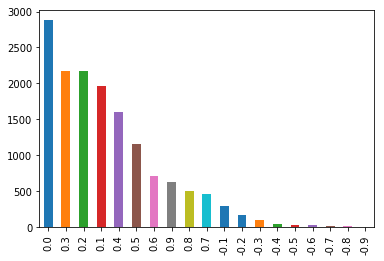

In [178]:
train.score.value_counts().plot(kind='bar')

## 3.4 Treatment of "Name" (Text) Feature and creating 3 new features

### 3.4.1 Name treatment 1:  Change "No name" "no name yet", "unknown", missing value to "no specific name"

In [ ]:
## code

### 3.4.2 Name treatment 2: language detection and creating 1 feature "name_lang"

In [5]:
def try_detect(cell):
    try:
        detected_lang = detect(cell)
    except:
        detected_lang = None
    return detected_lang

text_detect = []

for Name in train['Name']:
    lang = try_detect(Name)
    text_detect.append(lang)

#print(text_detect)
train['name_lang'] = train.Name.apply(try_detect)

In [6]:
train.name_lang.value_counts()

en    2931
de    1630
tl     860
sw     762
fi     719
id     711
pl     612
cy     571
it     483
af     418
so     389
tr     364
ro     348
pt     336
nl     273
fr     250
no     242
cs     214
da     183
es     173
ca     170
sv     159
vi     157
lt     157
hr     119
et     104
sq     100
hu      98
sk      86
sl      76
lv      12
Name: language_name, dtype: int64

### 3.4.3 Name treatment 3:  Removing punctuation, to lower case and creating 1 feature "name_freq"

In [13]:
train.Name.value_counts()

Baby                          66
Lucky                         64
No Name                       54
Brownie                       54
Mimi                          52
Blackie                       49
Puppy                         45
Kittens                       39
Max                           39
Kitty                         39
Oreo                          36
Coco                          35
Tiger                         34
Angel                         33
Milo                          32
Bobby                         30
Snowy                         30
Lucy                          29
Kiki                          29
Lily                          28
Tom                           27
Ginger                        26
Puppies                       26
Happy                         25
Prince                        25
Daisy                         24
Rocky                         23
Simba                         23
Kitten                        23
Bella                         23
          

In [14]:
## code

## 3.5 Create 1 feature "video_binary" based on whether there is video or not

In [ ]:
## code

## 3.6 Create 1 feature "quantity_one_binary" based on whether the quantity is one or not

In [ ]:
## code

## 4. Feature Selection

To do elbow plot on structured data here

## 5. Model 

## 5.1: Description vs Target

First, we investigated how well the Description feature can predict the target. We split the train data provided by the competition into train/test sets, used TF-IDF feature engineering and Logistic Regression algorithm. We got about 39% accuracy. Results hits that when target == 0, the prediction is not very well. We assume that if we do up-sampling to the categories that are underrepresentated in the target, the performance may improve. Therefore, we assume that using the Description feature to generate a model and use the predictions as the features of the first layer of our stacking model could be foreseeable way.

In [248]:
train = pd.read_csv('train_translated_desc.cleaned.csv')
train_desc, test_desc, train_speed, test_speed = train_test_split(train['desc_eng'], train['AdoptionSpeed'],
                                                   test_size=0.2,
                                                   random_state=1,
                                                   stratify=train['AdoptionSpeed'])

In [249]:
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv_train_features = tv.fit_transform(train_desc)
tv_test_features = tv.transform(test_desc)
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)


TFIDF model:> Train features shape: (11994, 201545)  Test features shape: (2999, 201545)


In [250]:
lr_tfidf_predictions = meu.train_predict_model(classifier=lr, 
                                               train_features=tv_train_features, train_labels=train_speed,
                                               test_features=tv_test_features, test_labels=test_speed)

meu.display_model_performance_metrics(true_labels=test_speed, predicted_labels=lr_tfidf_predictions,
                                      classes=[0,1,2,3,4])

/Users/zhanglingling/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/zhanglingling/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Model Performance metrics:
------------------------------
Accuracy: 0.3921
Precision: 0.3921
Recall: 0.3921
F1 Score: 0.369

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.67      0.02      0.05        82
           1       0.35      0.19      0.25       618
           2       0.35      0.41      0.37       807
           3       0.40      0.27      0.32       652
           4       0.43      0.66      0.52       840

   micro avg       0.39      0.39      0.39      2999
   macro avg       0.44      0.31      0.30      2999
weighted avg       0.39      0.39      0.37      2999


Prediction Confusion Matrix:
------------------------------
          Predicted:                    
                   0    1    2    3    4
Actual: 0          2   15   25    7   33
        1          0  117  205   71  225
        2          0   88  328  137  254
        3          1   58  203  176  214
        4          